# August 15, September 14, 2022: Create MAX trial level responses

In [1]:
import os 
import sys
from os.path import join as pjoin
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random

from nltools import mask
from nilearn import image, masking, plotting

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/aug22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils

/home/govindas/venvs/expln-ai3.9/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [6]:
subj = 'MAX101'
pjoin(proj_dir, 'data/max', 'data', subj + '_meanTS.1D')

'/home/govindas/network_dynamics/data/max/data/MAX101_meanTS.1D'

## good voxels

In [2]:
# set_name = 'mashid'
# mask_dir = f"{proj_dir}/data/rois/{set_name}/individual_nifti_files"
# final_mask_file = f"{mask_dir}/../final_mask_cortical+subcortical.nii.gz"

set_name = 'max'
final_mask_file = f"/home/govindas/parcellations/MAX_85_ROI_masks/MAX_ROIs_final_gm_85.nii.gz"

'''
good voxels

basic step taken from the script:
/home/govindas/vscode-BSWIFT-mnt/MAX/scripts/Murty_Final/ROI_analysis/trial_level/FNSandFNT/MAX_fMRI_Analysis_neutral_deconv_reducedRuns.sh
'''

main_mask_path = (
    f"/home/govindas/vscode-BSWIFT-mnt/MAX"
    f"/dataset/preproc/masksAndCensors"
)

for subj in tqdm(os.listdir(main_mask_path)):
    mask_path = (
        f"{main_mask_path}/{subj}"
    )

    mask_goodVoxels_file = f"{mask_path}/mask_{set_name}_goodVoxels.nii.gz"
    # if os.path.exists(mask_goodVoxels_file): continue
    mask_goodVoxels = image.math_img(
        f'img1 * img2 * img3',
        img1=f"{mask_path}/goodVoxelsMask.nii.gz",
        img2=f"{mask_path}/commonVoxelsMask.nii.gz",
        img3=f"{final_mask_file}"
    )    
    mask_goodVoxels.to_filename(mask_goodVoxels_file)

  0%|          | 0/109 [00:00<?, ?it/s]

## trial level responses

In [4]:
'''
run in terminal on bswift:
bash runDeconvolve.sh
'''

'\nrun in terminal on bswift:\nbash runDeconvolve.sh\n'

In [6]:
main_data_dir = (
    f"/home/govindas/network_dynamics/data/max"
    f"/neutral_runs_trial_level_FNSandFNT/{set_name}"
)

class ARGS(): pass
args = ARGS()

args.TRIAL_LEN = 14
args.LABELS = [0, 1] #safe, threat
args.LABEL_NAMES = ['FNS#', 'FNT#']

args.SEED = 74
np.random.seed(args.SEED)

args.subjects = os.listdir(main_data_dir)[:-1]
random.Random(args.SEED).shuffle(args.subjects)

'''
exploratory dataset
'''
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]
X, _, _ = dataset_utils.get_max_trial_level_responses(
    args, 
    main_data_dir,
    args.explor_subjects
)

with open(f"{proj_dir}/data/max/desc-exploratory_data_trial_level_responses_rois-{set_name}.pkl", 'wb') as f:
    pickle.dump(X, f)

100%|██████████| 27/27 [00:04<00:00,  5.40it/s]


In [7]:
for label, _ in enumerate(args.LABELS):
    print(f"{label}------")
    for x in X[label]:
        print(x.shape)

0------
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
1------
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)
(11, 14, 45)
(16, 14, 45)


In [8]:
'''
plot the activations
'''
num_rois = X[0][0].shape[2]
args.roi_idxs = np.arange(num_rois)

def plot_roi_time_series(args, X, savefig=False, fig_file=None):
    X_conds = {}
    X_ = {}
    for label in args.LABELS:
        X_[label] = np.concatenate(X[label], axis=0)
        X_conds[f"{label}_m"] = np.nanmean(X_[label], axis=0)
        X_conds[f"{label}_s"] = 1.96 * np.nanstd(X_[label], axis=0) / np.sqrt(X_[label].shape[0])

    roi_name_file = (
        f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"
    )
    roi_names =  pd.read_csv(
        roi_name_file
    )['roi_name']

    time = np.arange(X_[0].shape[1])
    names = ['safe', 'threat']
    colors = {0:'royalblue', 1:'firebrick'}
    nrows, ncols = int(np.ceil(len(args.roi_idxs)/5)), 5

    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=True, 
        dpi=150
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=None, hspace=0.5
    )

    for idx, roi in enumerate(args.roi_idxs):
        roi_name = roi_names[roi]
        if nrows > 1:
            ax = axs[idx//ncols, np.mod(idx,ncols)]
        else:
            ax = axs[idx]

        ax.set_title(f"{roi} {roi_name}")
        for label in args.LABELS:
            ts_mean = X_conds[f"{label}_m"][:, idx]
            ts_std = X_conds[f"{label}_s"][:, idx]

            ax.plot(ts_mean, color=colors[label], label=names[label])

            ax.fill_between(
                time, 
                (ts_mean - ts_std), 
                (ts_mean + ts_std),
                alpha=0.3, color=colors[label],
            )
        ax.set_xlabel(f"time")
        ax.set_ylabel(f"roi resp.")
        ax.grid(True)
        ax.legend()
        ax.set_ylim(-0.25, 0.25)

    if savefig:
        fig.savefig(
            fig_file,
            dpi=150,
            format='png',
            bbox_inches='tight',
            transparent=False
        )

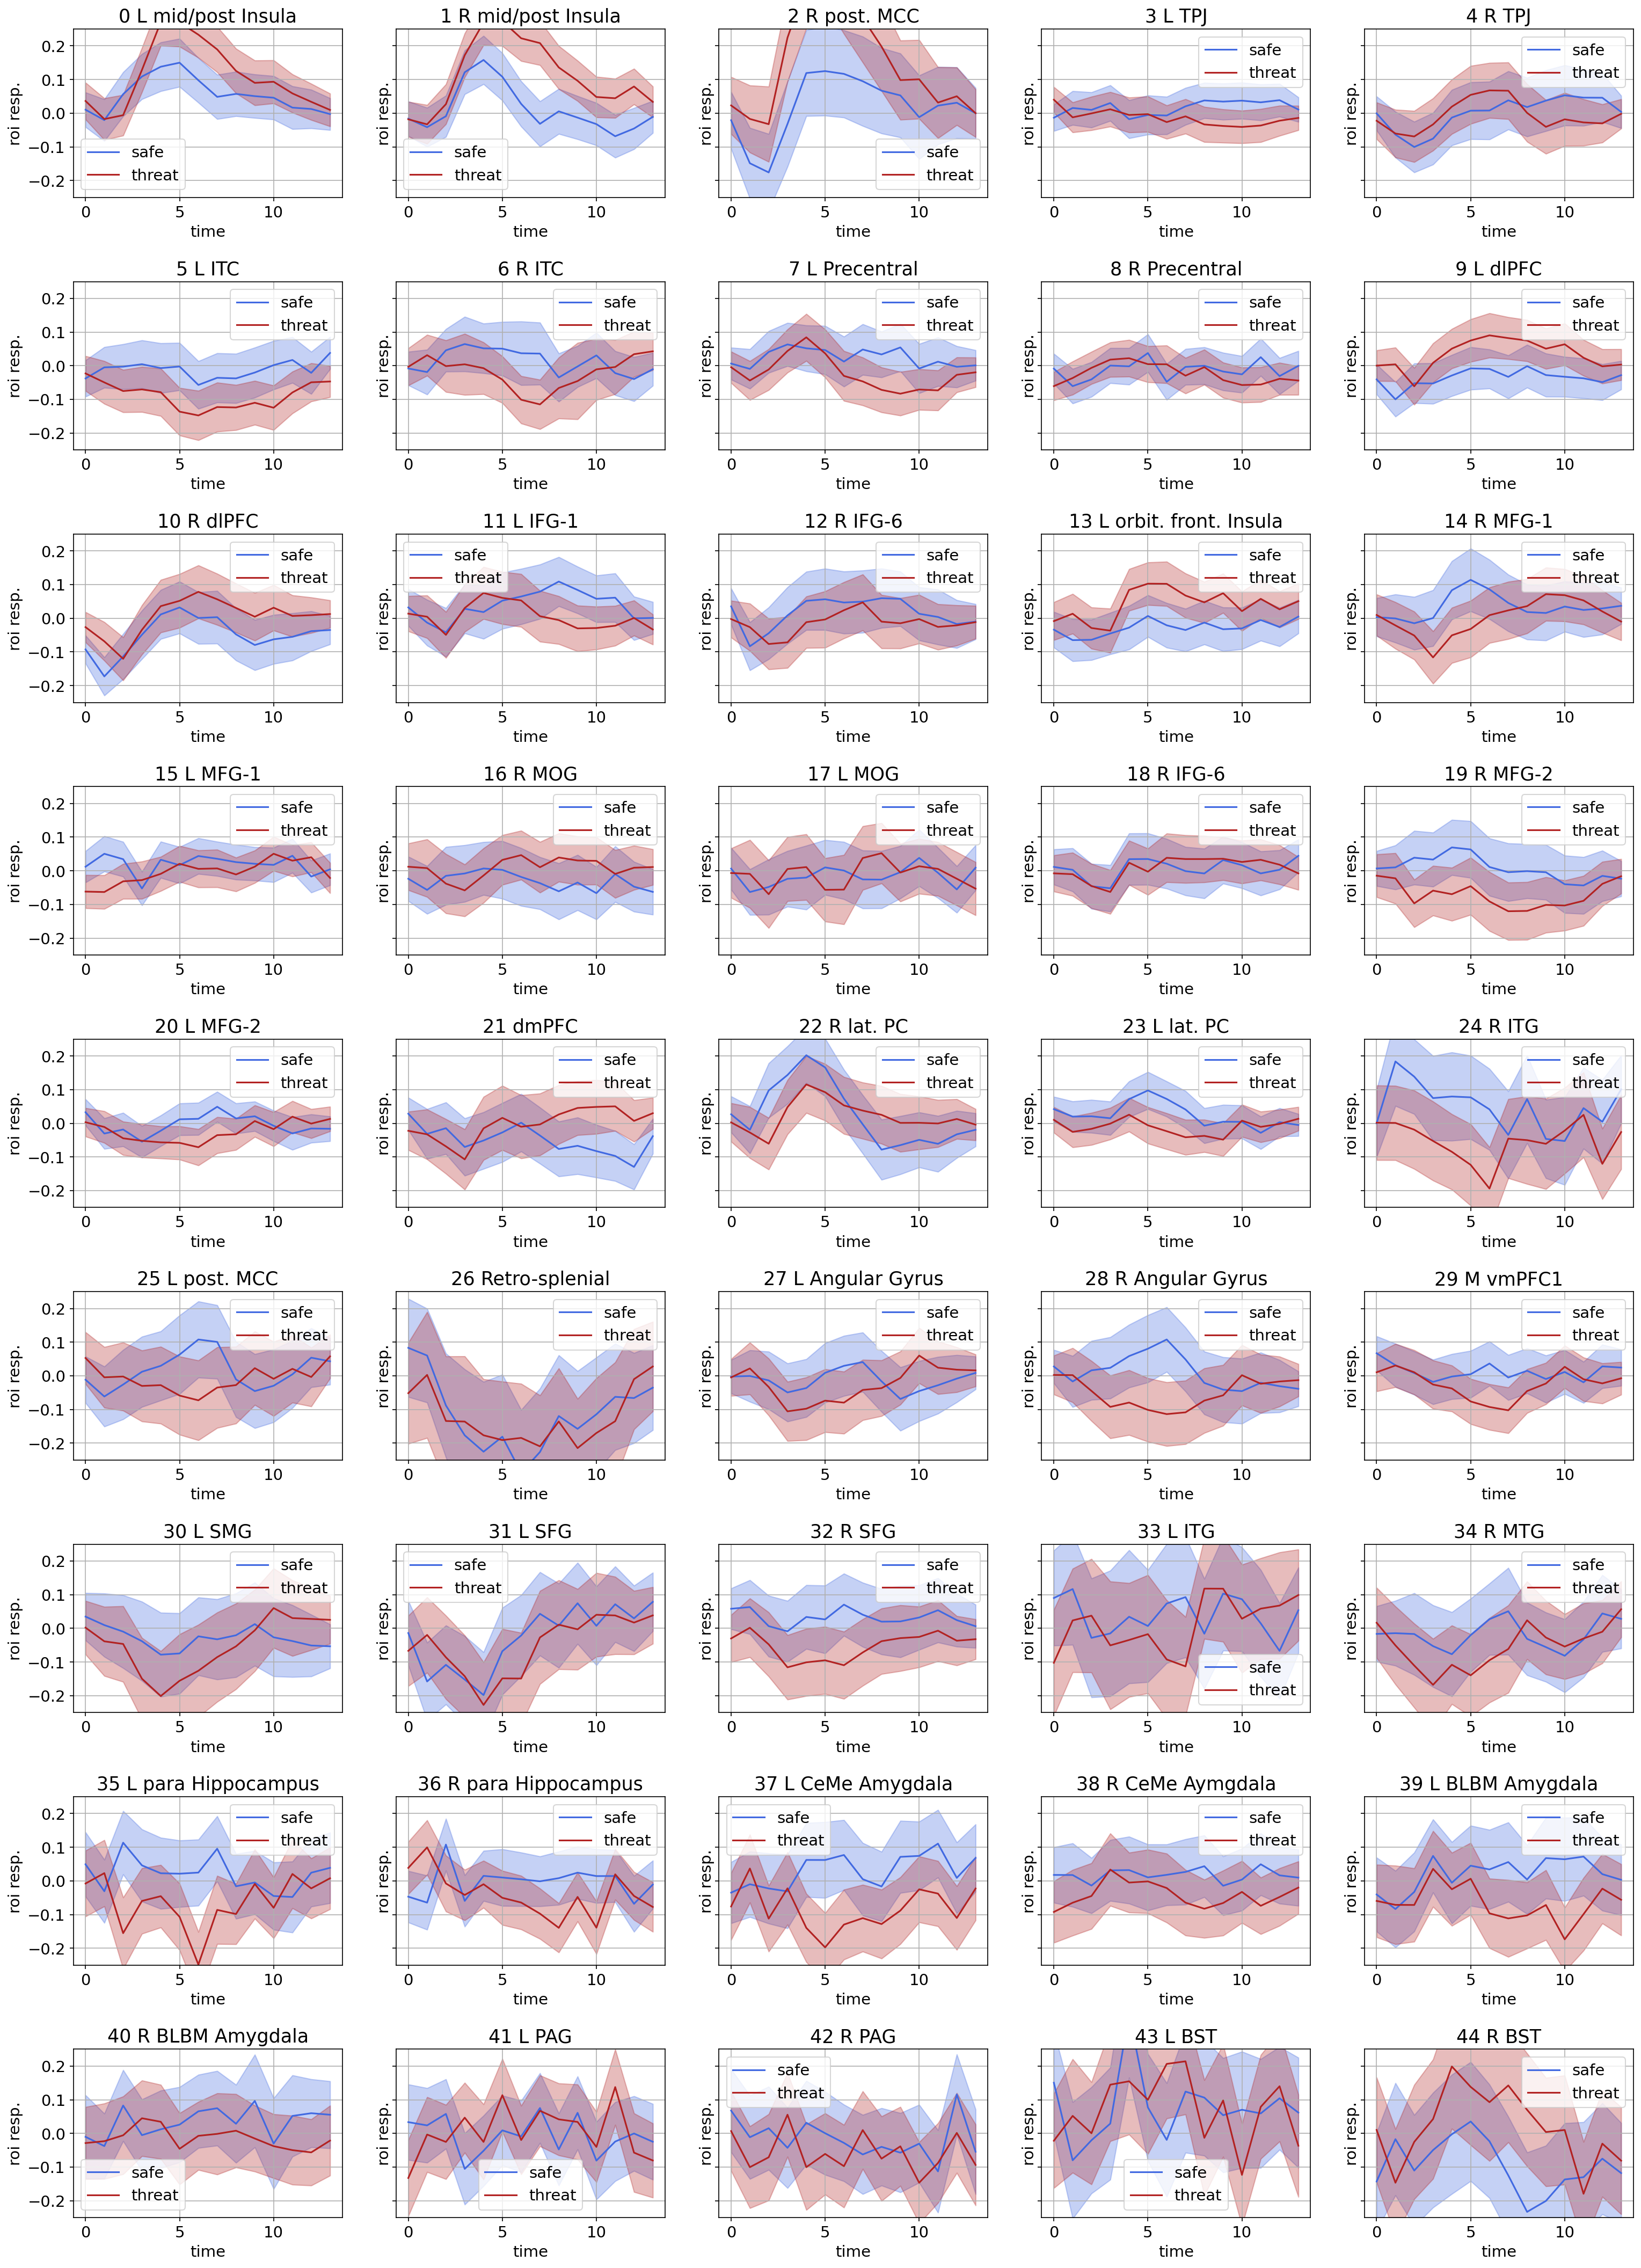

In [9]:
plot_roi_time_series(args, X)

In [ ]:
args.up_roi_idxs = np.array(
    list(range(0, 5)) +
    list(range(7, 14)) +
    [22, 23]
)

args.zero_roi_idxs = np.array(
    list(range(14, 22)) +
    list(range(33, 37))
)

args.down_roi_idxs = np.array(
    [5, 6] +
    list(range(24, 33))
)

args.roi_idxs = np.concatenate([args.up_roi_idxs, args.zero_roi_idxs, args.down_roi_idxs])

In [ ]:
len(args.roi_idxs)

In [ ]:
with open(f"{proj_dir}/data/max/exploratory_data_{set_name}_roi_indices.pkl", 'wb') as f:
    pickle.dump([args.up_roi_idxs, args.zero_roi_idxs, args.down_roi_idxs, args.roi_idxs], f)